In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

from sklearn.metrics import r2_score
from scipy.special import rel_entr

from biological_fuzzy_logic_networks.manuscripts_functions.colors import models_dict
from biological_fuzzy_logic_networks.manuscripts_functions.metrics import compute_scalar_mmd, wasserstein_distance

In [2]:
fontsize = 12

In [3]:
sns.set_theme(font="Arial", style="ticks", rc={"font.size": fontsize,"axes.titlesize":fontsize,"axes.labelsize":fontsize, 
                                               "xtick.labelsize": fontsize, "ytick.labelsize": fontsize, "legend.fontsize": fontsize})
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.size'] = fontsize


In [4]:
test_input = False
train_input = True
test_y = False
train_y = True

base_dir = "/dccstor/ipc1/CAR/BFN/Model/Noise/"
noise_range = 4
n_runs = 5

markers = [
        "mek12",
        "erk12",
        "mkk4",
        "jnk12",
        "ikk",
        "ikb",
        "ras",
        "map3k7",
        "igf1",
        "pi3k",
        "il1a",
        "map3k1",
        "tgfa",
        "tnfa",
        "akt",
        "p38",
        "hsp27",
    ]

output_markers = list(set(markers).difference(set(["igf1", "tgfa", "tnfa", "il1a"])))


In [5]:
def compute_MMD(data, markers=output_markers):
    data["cell_id"] = len(data['marker'].unique())*[i for i in range(int(len(data)/len(data["marker"].unique())))] 
    
    pred = data[["cell_id", "marker", "pred"]]
    pred = pred.set_index("cell_id").pivot(columns="marker")
    
    
    true = data[["cell_id", "marker", "true"]]
    true = true.set_index("cell_id").pivot(columns="marker")
    mmd = compute_scalar_mmd(true, pred)
    
    return mmd


def compute_wasserstein(data, markers=output_markers):
    data["cell_id"] = len(data['marker'].unique())*[i for i in range(int(len(data)/len(data["marker"].unique())))] 
    
    pred = data[["cell_id", "marker", "pred"]]
    pred = pred.set_index("cell_id").pivot(columns="marker")
    
    
    true = data[["cell_id", "marker", "true"]]
    true = true.set_index("cell_id").pivot(columns="marker")
    emd = wasserstein_distance(true, pred)
    
    return emd

def compute_R2(data):
    out = r2_score(data["true"], data['pred'])
    return out

# Baseline without noise

In [6]:
no_noise_outputs = []
no_noise_trues = []
for i in range(n_runs):
    
    run_output = pd.read_csv(os.path.join(base_dir, "Error_sd_0", f"{i+1}_unperturbed.csv"), index_col=1)
    run_output = run_output.rename(columns={"Unnamed: 0": "model"})
    run_output["noise_sd"] = 0
    run_output["repeat"] = i+1
    
    no_noise_outputs.append(run_output[run_output["model"]!="teacher_true"])
    no_noise_trues.append(run_output[run_output["model"]=="teacher_true"])

no_noise_output = pd.concat(no_noise_outputs).reset_index(drop=False)
no_noise_true = pd.concat(no_noise_trues).reset_index(drop=False).drop("model", axis=1)

no_noise_pred_long = no_noise_output.melt(id_vars=["index", "noise_sd", "repeat", "model"], var_name="marker", value_name="pred")
no_noise_true_long = no_noise_true.melt(id_vars=["index", "noise_sd", "repeat"], var_name="marker", value_name="true")

no_noise_df = no_noise_pred_long.merge(no_noise_true_long, on=["index", "repeat", "marker", "noise_sd"]).dropna()
no_noise_df = no_noise_df.drop("index", axis=1)
no_noise_df["error"] = (no_noise_df["true"] - no_noise_df["pred"])
no_noise_df["sq_err"] = no_noise_df["error"]**2
no_noise_df["abs_error"] = abs(no_noise_df["error"])
no_noise_df = no_noise_df[no_noise_df["model"]!="teacher_true"]
no_noise_df[(no_noise_df['marker']=="mek12")&(no_noise_df["model"]=="student_same_input")]

,noise_sd,repeat,model,marker,pred,true,error,sq_err,abs_error
0,0,1,student_same_input,mek12,0.553993,0.554040,4.758238e-05,2.264083e-09,4.758238e-05
6,0,1,student_same_input,mek12,0.409075,0.409097,2.236482e-05,5.001852e-10,2.236482e-05
12,0,1,student_same_input,mek12,0.027684,0.027665,-1.876393e-05,3.520850e-10,1.876393e-05
18,0,1,student_same_input,mek12,0.115785,0.115753,-3.138903e-05,9.852711e-10,3.138903e-05
24,0,1,student_same_input,mek12,0.042385,0.042361,-2.401674e-05,5.768036e-10,2.401674e-05
...,...,...,...,...,...,...,...,...,...
59970,0,5,student_same_input,mek12,0.456782,0.456782,2.364546e-07,5.591080e-14,2.364546e-07
59976,0,5,student_same_input,mek12,0.999999,0.999999,3.107492e-09,9.656504e-18,3.107492e-09
59982,0,5,student_same_input,mek12,0.962618,0.962676,5.798743e-05,3.362542e-09,5.798743e-05
59988,0,5,student_same_input,mek12,0.216360,0.216288,-7.186915e-05,5.165174e-09,7.186915e-05


In [7]:
no_noise_df

,noise_sd,repeat,model,marker,pred,true,error,sq_err,abs_error
0,0,1,student_same_input,mek12,0.553993,0.55404,0.000048,2.264083e-09,0.000048
1,0,1,student_random_input,mek12,0.640816,0.55404,-0.086776,7.530086e-03,0.086776
2,0,1,untrained_same_input,mek12,0.568200,0.55404,-0.014160,2.005038e-04,0.014160
3,0,1,untrained_random_input,mek12,0.819195,0.55404,-0.265155,7.030730e-02,0.265155
4,0,1,lm_same_input,mek12,0.572842,0.55404,-0.018801,3.534924e-04,0.018801
...,...,...,...,...,...,...,...,...,...
779995,0,5,student_random_input,hsp27,0.022954,1.00000,0.977046,9.546194e-01,0.977046
779996,0,5,untrained_same_input,hsp27,0.999840,1.00000,0.000160,2.554002e-08,0.000160
779997,0,5,untrained_random_input,hsp27,0.020133,1.00000,0.979867,9.601388e-01,0.979867
779998,0,5,lm_same_input,hsp27,0.907689,1.00000,0.092311,8.521313e-03,0.092311


In [8]:
no_noise_grouped = no_noise_df.groupby(["noise_sd", "repeat", "model", "marker"]).mean()
no_noise_grouped["R2"] = no_noise_df.groupby(["noise_sd", "repeat", "model", "marker"]).apply(compute_R2)
no_noise_grouped = no_noise_grouped.reset_index(drop=False)
no_noise_grouped = no_noise_grouped.rename(columns={"sq_err": "MSE"})
no_noise_grouped

,noise_sd,repeat,model,marker,pred,true,error,MSE,abs_error,R2
0,0,1,lm_random_input,akt,0.921456,0.922444,0.000988,0.054773,0.164369,-0.554406
1,0,1,lm_random_input,erk12,0.342595,0.344646,0.002050,0.357890,0.492454,-0.842945
2,0,1,lm_random_input,hsp27,0.434455,0.435443,0.000988,0.419603,0.529794,-0.807468
3,0,1,lm_random_input,ikb,0.885069,0.888875,0.003806,0.107847,0.240474,-0.484010
4,0,1,lm_random_input,ikk,0.873246,0.875860,0.002613,0.098046,0.238533,-0.586634
...,...,...,...,...,...,...,...,...,...,...
385,0,5,untrained_same_input,mek12,0.298353,0.506399,0.208046,0.079817,0.208046,0.489830
386,0,5,untrained_same_input,mkk4,0.453623,0.482360,0.028738,0.012885,0.069375,0.931875
387,0,5,untrained_same_input,p38,0.360945,0.453708,0.092763,0.040438,0.101187,0.801148
388,0,5,untrained_same_input,pi3k,0.876783,0.878968,0.002185,0.004754,0.037890,0.894833


In [9]:
no_noise_mmd = no_noise_df.groupby(["noise_sd", "repeat", "model"]).mean(numeric_only=True)
no_noise_mmd["MMD"] = no_noise_df.groupby(["noise_sd", "repeat", "model"]).apply(compute_MMD)
no_noise_mmd["EMD"] = no_noise_df.groupby(["noise_sd", "repeat", "model"]).apply(compute_wasserstein)


2024-07-05 06:08:40.846695: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_DEVICE_UNAVAILABLE: CUDA-capable device(s) is/are busy or unavailable
CUDA backend failed to initialize: INTERNAL: no supported devices found for platform CUDA (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [18]:
no_noise_mmd

pred      true     error  \
noise_sd repeat model                                                  
0        1      lm_random_input         0.608562  0.610344  0.001783   
                lm_same_input           0.610876  0.610344 -0.000532   
                student_random_input    0.605662  0.610344  0.004682   
                student_same_input      0.610428  0.610344 -0.000084   
                untrained_random_input  0.527455  0.610344  0.082889   
                untrained_same_input    0.539781  0.610344  0.070563   
         2      lm_random_input         0.628284  0.632735  0.004451   
                lm_same_input           0.636590  0.632735 -0.003855   
                student_random_input    0.628637  0.632735  0.004098   
                student_same_input      0.632991  0.632735 -0.000256   
                untrained_random_input  0.504453  0.632735  0.128282   
                untrained_same_input    0.516216  0.632735  0.116519   
         3      lm_random_input         0.565474  0.569550  0.004076   
                lm_same_input           0.569553  0.569550 -0.000003   
                student_random_input    0.566976  0.569550  0.002574   
                student_same_input      0.569591  0.569550 -0.000041   
                untrained_random_input  0.596063  0.569550 -0.026513   
                untrained_same_input    0.594694  0.569550 -0.025144   
         4      lm_random_input         0.586325  0.575067 -0.011258   
                lm_same_input           0.575735  0.575067 -0.000669   
                student_random_input    0.584789  0.575067 -0.009723   
                student_same_input      0.575110  0.575067 -0.000044   
                untrained_random_input  0.564268  0.575067  0.010799   
                untrained_same_input    0.557920  0.575067  0.017146   
         5      lm_random_input         0.597338  0.595220 -0.002118   
                lm_same_input           0.598361  0.595220 -0.003141   
                student_random_input    0.595732  0.595220 -0.000512   
                student_same_input      0.595243  0.595220 -0.000023   
                untrained_random_input  0.542458  0.595220  0.052763   
                untrained_same_input    0.539476  0.595220  0.055744   

                                              sq_err  abs_error           MMD  \
noise_sd repeat model                                                           
0        1      lm_random_input         2.434332e-01   0.376235  2.468394e-02   
                lm_same_input           2.750741e-02   0.131149  2.335700e-02   
                student_random_input    2.704577e-01   0.355056  1.931836e-04   
                student_same_input      2.675794e-06   0.000563  6.407499e-07   
                untrained_random_input  2.657601e-01   0.371009  3.035772e-02   
                untrained_same_input    3.272588e-02   0.093738  2.608421e-02   
         2      lm_random_input         2.641807e-01   0.407549  2.511327e-02   
                lm_same_input           3.005553e-02   0.141351  2.337670e-02   
                student_random_input    2.952323e-01   0.388418  6.053050e-04   
                student_same_input      7.083860e-06   0.001063  2.716978e-06   
                untrained_random_input  2.947624e-01   0.401908  4.136251e-02   
                untrained_same_input    6.334519e-02   0.127712  3.770475e-02   
         3      lm_random_input         2.593004e-01   0.403092  2.486661e-02   
                lm_same_input           3.131199e-02   0.140186  2.548565e-02   
                student_random_input    2.913359e-01   0.389317  3.527974e-04   
                student_same_input      8.784290e-07   0.000287  5.190571e-07   
                untrained_random_input  2.686340e-01   0.376805  9.909786e-03   
                untrained_same_input    1.805777e-02   0.069624  1.124993e-02   
         4      lm_random_input         2.694804e-01   0.409361  2.153176e-02   
                lm_same_input         

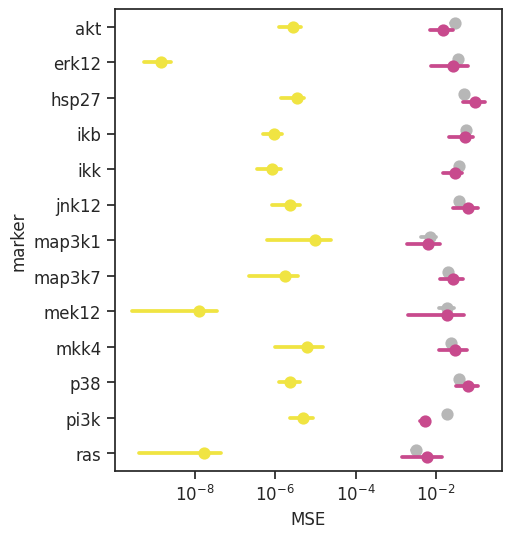

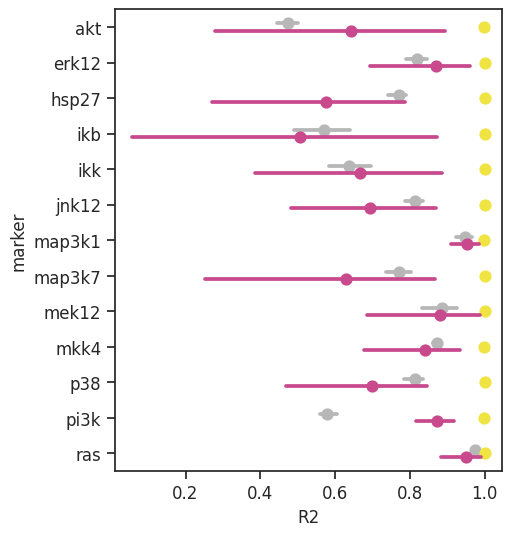

In [36]:
# temp = no_noise_grouped[no_noise_grouped["model"].isin(["student_same_input", "untrained_same_input", "lm_same_input"])]
# sns.boxplot(data=temp, y="marker", x="MSE", hue="model", palette=models_dict)
# plt.xscale('log')
# plt.legend([], [], frameon=False)
# plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/No_noise_same_input_MSE.pdf", bbox_inches="tight")
# plt.show()

# temp = no_noise_grouped[no_noise_grouped["model"].isin(["student_same_input", "untrained_same_input", "lm_same_input"])]
# sns.boxplot(data=temp, y="marker", x="R2", hue="model", palette=models_dict)
# plt.legend([], [], frameon=False)
# plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/No_noise_same_input_R2.pdf", bbox_inches="tight")
# plt.show()

temp = no_noise_grouped[no_noise_grouped["model"].isin(["student_same_input", "untrained_same_input", "lm_same_input"])]
plt.figure(figsize=(5,6))
sns.pointplot(data=temp, y="marker", x="MSE", hue="model", palette=models_dict, linestyles="none", dodge=0.2)
plt.xscale('log')
plt.legend([], [], frameon=False)
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/No_noise_same_input_MSE_pointplot.pdf", bbox_inches="tight")
plt.show()

temp = no_noise_grouped[no_noise_grouped["model"].isin(["student_same_input", "untrained_same_input", "lm_same_input"])]
plt.figure(figsize=(5,6))
sns.pointplot(data=temp, y="marker", x="R2", hue="model", palette=models_dict, linestyles="none", dodge=0.2)
plt.legend([], [], frameon=False)
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/No_noise_same_input_R2_pointplot.pdf", bbox_inches="tight")
plt.show()

# Load experiments

In [15]:
experiment_name = []

if train_input:
    experiment_name.append("tri")
if train_y:
    experiment_name.append("try")
if test_input:
    experiment_name.append("tei")
if test_y:
    experiment_name.append("tey")
    
experiment_name = "_".join(experiment_name)
print(experiment_name)

tri_try


In [16]:
experiment_names= ["tei", "tri", "tri_tei", "tri_try_tei"]

In [17]:
outputs = []
trues = []
for i in range(n_runs):
    for n in range(noise_range):
        run_output = pd.read_csv(os.path.join(base_dir, f"Error_sd_{n+1}", experiment_name, f"{i+1}_unperturbed.csv"), index_col=1)
        run_output = run_output.rename(columns={"Unnamed: 0": "model"})
        run_output["noise_sd"] = n+1
        run_output["repeat"] = i+1
        
        outputs.append(run_output[run_output["model"]!="teacher_true"])
        trues.append(run_output[run_output["model"]=="teacher_true"])

In [18]:
run_output

,model,mek12,erk12,mkk4,jnk12,ikk,ikb,ras,map3k7,pi3k,map3k1,akt,p38,hsp27,igf1,il1a,tgfa,tnfa,noise_sd,repeat
0,teacher_true,0.471633,0.508736,0.496730,0.468021,0.472511,0.507663,0.516666,0.479031,0.476271,0.523889,0.492047,0.489536,0.508696,0.490030,0.494540,0.479920,0.501843,4,5
1,teacher_true,0.483096,0.532737,0.496507,0.467966,0.465631,0.503129,0.525206,0.470088,0.475265,0.522736,0.492039,0.489503,0.508692,0.473982,0.492392,0.485461,0.487693,4,5
2,teacher_true,0.481405,0.532334,0.496628,0.467989,0.468116,0.504473,0.523258,0.471304,0.473212,0.526346,0.491846,0.489507,0.508695,0.459918,0.497959,0.484062,0.486220,4,5
3,teacher_true,0.484238,0.532761,0.532944,0.502734,0.499665,0.533490,0.527796,0.498107,0.476255,0.555290,0.492047,0.523956,0.541175,0.478769,0.519257,0.487763,0.498452,4,5
4,teacher_true,0.452838,0.497942,0.497163,0.468119,0.471086,0.506499,0.499780,0.477630,0.459927,0.527304,0.475790,0.489584,0.508694,0.471473,0.500811,0.465265,0.497300,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,lm_random_input,0.547656,0.295789,0.442329,0.500527,0.717804,0.731439,0.550218,0.657014,0.862869,0.574747,0.868642,0.413818,0.407754,NaN,NaN,NaN,NaN,4,5
1996,lm_random_input,0.551860,0.290078,0.441562,0.512011,0.727195,0.729365,0.547758,0.663607,0.870853,0.561074,0.872361,0.418882,0.411763,NaN,NaN,NaN,NaN,4,5
1997,lm_random_input,0.554784,0.291140,0.442872,0.508996,0.726246,0.724601,0.545438,0.662865,0.875409,0.559463,0.873233,0.418814,0.411524,NaN,NaN,NaN,NaN,4,5
1998,lm_random_input,0.542569,0.292975,0.437817,0.496387,0.724652,0.737096,0.548865,0.660191,0.865720,0.568780,0.863758,0.417542,0.399568,NaN,NaN,NaN,NaN,4,5


In [19]:
true = pd.concat(trues).reset_index(drop=False).drop("model", axis=1)
output = pd.concat(outputs).reset_index(drop=False)
# output.loc[output["hsp27"]<-10, "hsp27"] = -10 # For outliers in tri_try_tei
true

,index,mek12,erk12,mkk4,jnk12,ikk,ikb,ras,map3k7,pi3k,map3k1,akt,p38,hsp27,igf1,il1a,tgfa,tnfa,noise_sd,repeat
0,0,0.525181,0.521761,0.501808,0.466408,0.478286,0.513877,0.521461,0.504866,0.541175,0.477761,0.513975,0.469138,0.446027,0.484788,0.500430,0.546482,0.543870,1,1
1,1,0.505266,0.493996,0.496575,0.459452,0.478281,0.513877,0.516559,0.504855,0.541132,0.461783,0.513975,0.465995,0.444674,0.443245,0.488423,0.543320,0.544858,1,1
2,2,0.452856,0.445280,0.602606,0.582083,0.478295,0.513877,0.479027,0.506335,0.541185,0.556764,0.513975,0.579963,0.581818,0.536924,0.558095,0.515394,0.527357,1,1
3,3,0.464959,0.452959,0.580567,0.579936,0.478291,0.513877,0.499194,0.489981,0.539456,0.540774,0.513953,0.571474,0.580212,0.517156,0.540313,0.531625,0.480339,1,1
4,4,0.454875,0.446440,0.494225,0.455246,0.430928,0.483764,0.485149,0.444727,0.520520,0.467109,0.505059,0.464068,0.444217,0.463323,0.493180,0.520795,0.475427,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,1995,0.466690,0.501861,0.521727,0.497509,0.498192,0.533476,0.513638,0.488978,0.475822,0.546830,0.492046,0.510222,0.523131,0.487626,0.510542,0.478028,0.498067,4,5
39996,1996,0.484460,0.532761,0.496520,0.467968,0.466008,0.503314,0.530295,0.470063,0.476308,0.523532,0.492047,0.489503,0.508692,0.466441,0.493925,0.492714,0.486618,4,5
39997,1997,0.483239,0.532745,0.496562,0.467976,0.466991,0.503829,0.525424,0.471093,0.475512,0.524573,0.492043,0.489504,0.508693,0.476352,0.495617,0.485629,0.488256,4,5
39998,1998,0.458823,0.498645,0.499053,0.468777,0.499664,0.533490,0.507603,0.498336,0.476308,0.526891,0.492047,0.490930,0.509036,0.471242,0.498537,0.473756,0.517486,4,5


In [20]:
pred_long = output.melt(id_vars=["index", "noise_sd", "repeat", "model"], var_name="marker", value_name="pred")
true_long = true.melt(id_vars=["index","noise_sd", "repeat"], var_name="marker", value_name="true")
true_long

,index,noise_sd,repeat,marker,true
0,0,1,1,mek12,0.525181
1,1,1,1,mek12,0.505266
2,2,1,1,mek12,0.452856
3,3,1,1,mek12,0.464959
4,4,1,1,mek12,0.454875
...,...,...,...,...,...
679995,1995,4,5,tnfa,0.498067
679996,1996,4,5,tnfa,0.486618
679997,1997,4,5,tnfa,0.488256
679998,1998,4,5,tnfa,0.517486


In [21]:
df = pred_long.merge(true_long, on=["index", "noise_sd", "repeat", "marker"]).dropna()
df = df.drop("index", axis=1)
df["error"] = (df["true"] - df["pred"])
df["sq_err"] = df["error"]**2
df["abs_error"] = abs(df["error"])
df

,noise_sd,repeat,model,marker,pred,true,error,sq_err,abs_error
0,1,1,student_same_input,mek12,0.508529,0.525181,0.016653,0.000277,0.016653
1,1,1,student_random_input,mek12,0.234649,0.525181,0.290532,0.084409,0.290532
2,1,1,untrained_same_input,mek12,0.249456,0.525181,0.275726,0.076025,0.275726
3,1,1,untrained_random_input,mek12,0.104088,0.525181,0.421093,0.177320,0.421093
4,1,1,lm_same_input,mek12,0.355998,0.525181,0.169184,0.028623,0.169184
...,...,...,...,...,...,...,...,...,...
3119995,4,5,student_random_input,hsp27,0.677586,0.541175,-0.136410,0.018608,0.136410
3119996,4,5,untrained_same_input,hsp27,0.021193,0.541175,0.519983,0.270382,0.519983
3119997,4,5,untrained_random_input,hsp27,0.049572,0.541175,0.491604,0.241674,0.491604
3119998,4,5,lm_same_input,hsp27,0.409943,0.541175,0.131232,0.017222,0.131232


In [24]:
avg_error = df.groupby(['noise_sd', "repeat", "model", "marker"]).mean()
avg_error["R2"] = df.groupby(["noise_sd", "repeat", "model", "marker"]).apply(compute_R2)
avg_error = avg_error.reset_index(drop=False)
avg_error = avg_error.rename(columns = {"sq_err": "MSE"})
avg_error = pd.concat([avg_error, no_noise_grouped])
avg_error

,noise_sd,repeat,model,marker,pred,true,error,MSE,abs_error,R2
0,1,1,lm_random_input,akt,0.916377,0.504167,-0.412210,0.170586,0.412210,-301.692945
1,1,1,lm_random_input,erk12,0.344304,0.484439,0.140135,0.023131,0.140135,-7.325109
2,1,1,lm_random_input,hsp27,0.423851,0.504113,0.080262,0.011875,0.085634,-1.699993
3,1,1,lm_random_input,ikb,0.876860,0.500513,-0.376346,0.142923,0.376346,-134.993861
4,1,1,lm_random_input,ikk,0.867002,0.462978,-0.404024,0.164517,0.404024,-173.884140
...,...,...,...,...,...,...,...,...,...,...
385,0,5,untrained_same_input,mek12,0.298353,0.506399,0.208046,0.079817,0.208046,0.489830
386,0,5,untrained_same_input,mkk4,0.453623,0.482360,0.028738,0.012885,0.069375,0.931875
387,0,5,untrained_same_input,p38,0.360945,0.453708,0.092763,0.040438,0.101187,0.801148
388,0,5,untrained_same_input,pi3k,0.876783,0.878968,0.002185,0.004754,0.037890,0.894833


In [25]:
error_mmd = df.groupby(["noise_sd", "repeat", "model"]).mean(numeric_only=True)
error_mmd["MMD"] = df.groupby(["noise_sd", "repeat", "model"]).apply(compute_MMD)
error_mmd["EMD"] = df.groupby(["noise_sd", "repeat", "model"]).apply(compute_wasserstein)
mmd_emd = pd.concat([error_mmd, no_noise_mmd])
mmd_emd = mmd_emd.reset_index(drop=False)
mmd_emd["EMD"] = mmd_emd["EMD"].astype(float)

In [32]:
mmd_emd

,noise_sd,repeat,model,pred,true,error,sq_err,abs_error,MMD,EMD
0,1,1,lm_random_input,0.601488,0.502852,-0.098636,0.064206,0.204573,5.601793e-01,0.911143
1,1,1,lm_same_input,0.602985,0.502852,-0.100132,0.062275,0.200743,5.610271e-01,0.912063
2,1,1,student_random_input,0.545232,0.502852,-0.042380,0.087132,0.253567,2.070698e-01,0.960331
3,1,1,student_same_input,0.479491,0.502852,0.023361,0.001447,0.029595,9.525637e-03,0.197491
4,1,1,untrained_random_input,0.554135,0.502852,-0.051283,0.171066,0.384495,4.671990e-01,1.452309
...,...,...,...,...,...,...,...,...,...,...
145,0,5,lm_same_input,0.598361,0.595220,-0.003141,0.025649,0.127571,1.875429e-02,0.847502
146,0,5,student_random_input,0.595732,0.595220,-0.000512,0.303350,0.401787,2.859657e-04,0.542040
147,0,5,student_same_input,0.595243,0.595220,-0.000023,0.000002,0.000572,7.102887e-07,0.517493
148,0,5,untrained_random_input,0.542458,0.595220,0.052763,0.271003,0.380729,2.123509e-02,0.797179


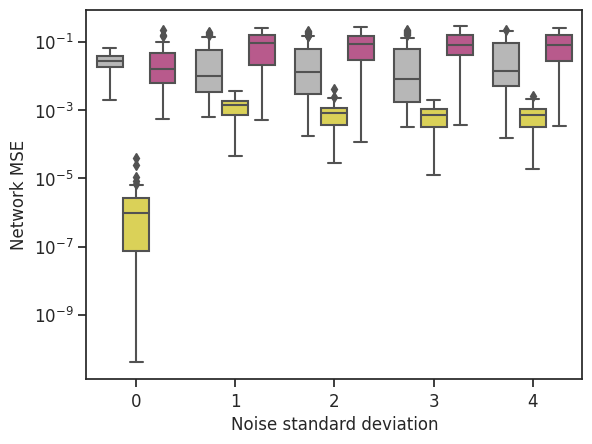

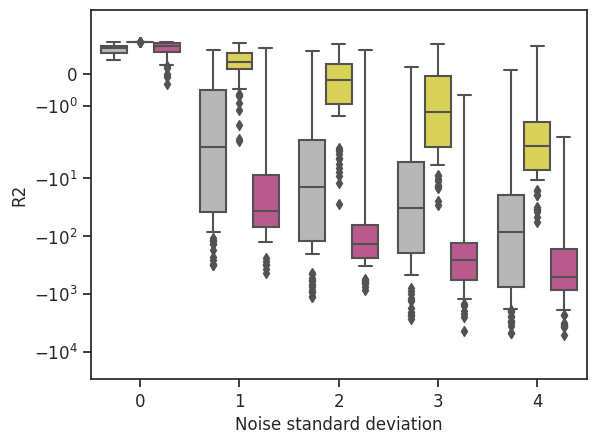

In [42]:
sns.boxplot(data=avg_error[avg_error["model"].isin(["untrained_same_input", "student_same_input", "lm_same_input"])], 
            x="noise_sd", y="MSE", hue="model", palette=models_dict)
plt.legend([], [], frameon=False)
plt.xlabel("Noise standard deviation")
plt.ylabel("Network MSE")
plt.yscale("log")
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Noise_{experiment_name}_MSE_same_inputs_avg_over_nodes_noise_sd.pdf", bbox_inches="tight")
plt.show()

sns.boxplot(data=avg_error[avg_error["model"].isin(["untrained_same_input", "student_same_input", "lm_same_input"])], 
            x="noise_sd", y="R2", hue="model", palette=models_dict)
plt.ylim((-3e4, 2))
plt.xlabel("Noise standard deviation")
plt.yscale("symlog")
plt.legend([], [], frameon=False)
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Noise_{experiment_name}_R2_same_inputs_avg_over_nodes_noise_sd.pdf", bbox_inches="tight")
plt.show()


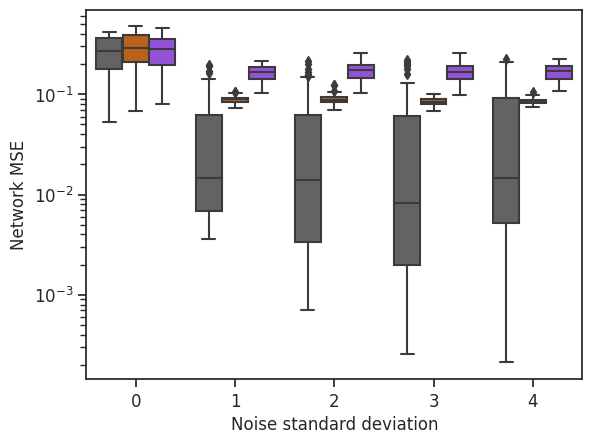

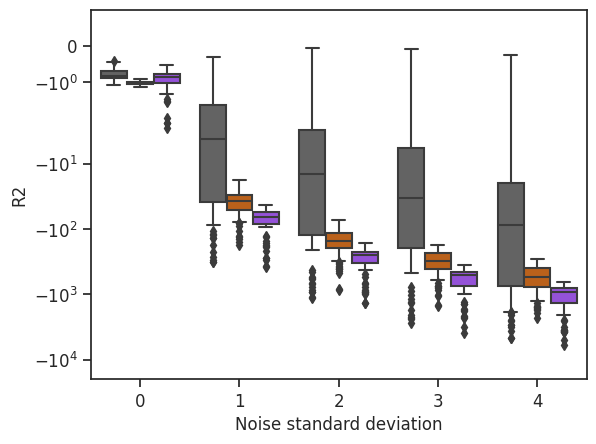

In [35]:
sns.boxplot(data=avg_error[avg_error["model"].isin(["untrained_random_input", "student_random_input", "lm_random_input"])], 
            x="noise_sd", y="MSE", hue="model", palette=models_dict)
plt.legend([], [], frameon=False)
plt.xlabel("Noise standard deviation")
plt.ylabel("Network MSE")
plt.yscale("log")
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Noise_{experiment_name}_MSE_random_inputs_avg_over_nodes_noise_sd.pdf", bbox_inches="tight")
plt.show()

sns.boxplot(data=avg_error[avg_error["model"].isin(["untrained_random_input", "student_random_input", "lm_random_input"])], 
            x="noise_sd", y="R2", hue="model", palette=models_dict)
plt.legend([], [], frameon=False)
plt.ylim((-2e4, 1))
plt.xlabel("Noise standard deviation")
plt.yscale("symlog")
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Noise_{experiment_name}_R2_random_inputs_avg_over_nodes_noise_sd.pdf", bbox_inches="tight")
plt.show()

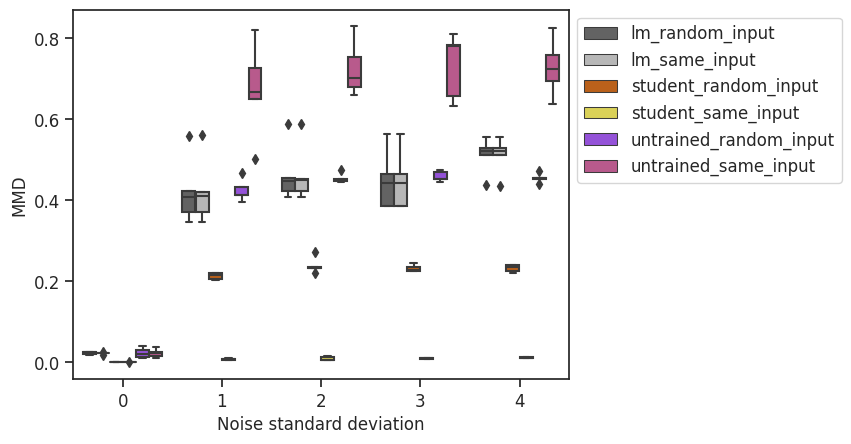

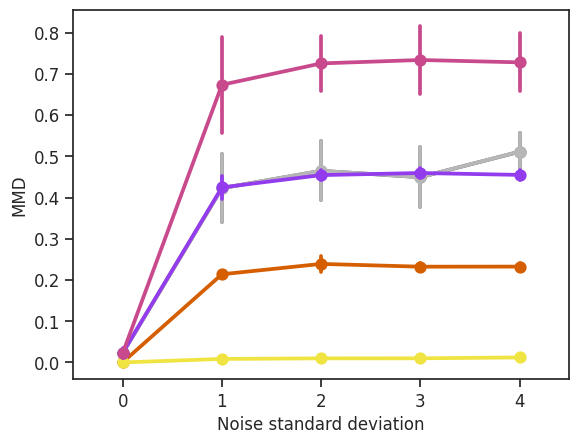

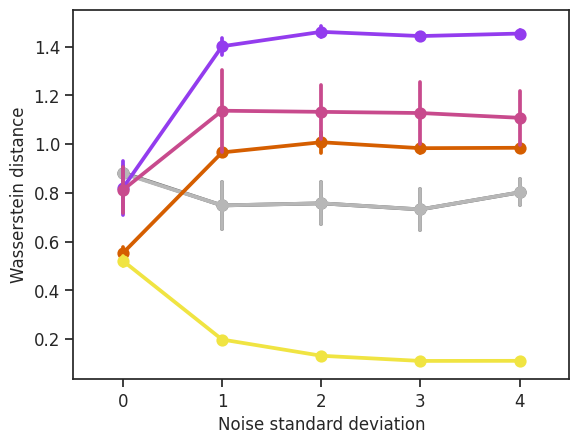

In [41]:
sns.boxplot(data=mmd_emd, x="noise_sd", 
            y="MMD", hue="model", palette=models_dict)
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("Noise standard deviation")
# plt.yscale("symlog")
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Noise_{experiment_name}_legend.pdf", bbox_inches="tight")
plt.show()

sns.pointplot(data=mmd_emd, x="noise_sd", 
            y="MMD", hue="model", palette=models_dict, errorbar="sd")
plt.legend([], [], frameon=False)
plt.xlabel("Noise standard deviation")
# plt.yscale("symlog")
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Noise_{experiment_name}_MMD_avg_over_nodes_noise_sd_pointplot.pdf", bbox_inches="tight")
plt.show()

sns.pointplot(data=mmd_emd, x="noise_sd", 
            y="EMD", hue="model", palette=models_dict, errorbar="sd")
plt.legend([], [], frameon=False)
plt.xlabel("Noise standard deviation")
plt.ylabel("Wasserstein distance")
# plt.yscale("log")
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Noise_{experiment_name}_EMD_avg_over_nodes_noise_sd_pointplot.pdf", bbox_inches="tight")
plt.show()

In [37]:
mmd_emd

,noise_sd,repeat,model,pred,true,error,sq_err,abs_error,MMD,EMD
0,1,1,lm_random_input,0.601488,0.502852,-0.098636,0.064206,0.204573,5.601793e-01,0.911143
1,1,1,lm_same_input,0.602985,0.502852,-0.100132,0.062275,0.200743,5.610271e-01,0.912063
2,1,1,student_random_input,0.545232,0.502852,-0.042380,0.087132,0.253567,2.070698e-01,0.960331
3,1,1,student_same_input,0.479491,0.502852,0.023361,0.001447,0.029595,9.525637e-03,0.197491
4,1,1,untrained_random_input,0.554135,0.502852,-0.051283,0.171066,0.384495,4.671990e-01,1.452309
...,...,...,...,...,...,...,...,...,...,...
145,0,5,lm_same_input,0.598361,0.595220,-0.003141,0.025649,0.127571,1.875429e-02,0.847502
146,0,5,student_random_input,0.595732,0.595220,-0.000512,0.303350,0.401787,2.859657e-04,0.542040
147,0,5,student_same_input,0.595243,0.595220,-0.000023,0.000002,0.000572,7.102887e-07,0.517493
148,0,5,untrained_random_input,0.542458,0.595220,0.052763,0.271003,0.380729,2.123509e-02,0.797179


In [38]:
dist_stats = mmd_emd.groupby(["noise_sd", "model"]).mean()[["MMD", "EMD"]].rename(columns={'MMD': "MMD_mean", "EMD": "EMD_mean"})
dist_stats = dist_stats.merge(mmd_emd.groupby(["noise_sd", 
                                               "model"]).std()[["MMD", 
                                                                "EMD"]].rename(columns={'MMD': "MMD_std", 
                                                                                        "EMD": "EMD_std"}), 
                                                                                left_index=True, right_index=True)
dist_stats

MMD_mean  EMD_mean       MMD_std   EMD_std
noise_sd model                                                             
0        lm_random_input         0.023024  0.882667  2.717925e-03  0.028400
         lm_same_input           0.022986  0.880115  2.519516e-03  0.031177
         student_random_input    0.000452  0.552718  2.568984e-04  0.025451
         student_same_input      0.000001  0.521509  9.467131e-07  0.019580
         untrained_random_input  0.023336  0.819837  1.274397e-02  0.111139
         untrained_same_input    0.022692  0.811805  1.023837e-02  0.092509
1        lm_random_input         0.422612  0.748464  8.246245e-02  0.096986
         lm_same_input           0.422843  0.748633  8.292285e-02  0.097609
         student_random_input    0.213928  0.965978  7.853277e-03  0.013068
         student_same_input      0.008529  0.198315  2.012862e-03  0.003669
         untrained_random_input  0.424631  1.401613  2.702637e-02  0.034589
         untrained_same_input    0.673531  1.137155  1.171076e-01  0.169003
2        lm_random_input         0.464798  0.757079  7.117805e-02  0.085518
         lm_same_input           0.464904  0.757176  7.116893e-02  0.085536
         student_random_input    0.239036  1.007818  1.946880e-02  0.043010
         student_same_input      0.009938  0.131683  4.372634e-03  0.012094
         untrained_random_input  0.454458  1.460830  1.212417e-02  0.022087
         untrained_same_input    0.725377  1.132467  6.768941e-02  0.111375
3        lm_random_input         0.449389  0.732019  7.263140e-02  0.085861
         lm_same_input           0.449583  0.732236  7.249760e-02  0.085719
         student_random_input    0.232284  0.983440  8.217872e-03  0.019799
         student_same_input      0.010042  0.110418  1.631605e-03  0.006217
         untrained_random_input  0.459562  1.443483  1.267531e-02  0.012981
         untrained_same_input    0.733685  1.127644  8.133738e-02  0.125340
4        lm_random_input         0.511139  0.802077  4.454395e-02  0.053045
         lm_same_input           0.511286  0.802249  4.466328e-02  0.053207
         student_random_input    0.232498  0.985054  8.698523e-03  0.014553
         student_same_input      0.012160  0.110863  1.152289e-03  0.004307
         untrained_random_input  0.454915  1.453761  1.157878e-02  0.014682
         untrained_same_input    0.727932  1.108046  7.004375e-02  0.111961

In [39]:
error_stats = avg_error.groupby(["noise_sd", "model"]).mean()[["MSE", "R2"]].rename(columns={'MSE': "MSE_mean", "R2": "R2_mean"})
error_stats = error_stats.merge(avg_error.groupby(["noise_sd", 
                                                   "model"]).std()[["MSE", 
                                                                    "R2"]].rename(columns={'MSE': "MSE_std", 
                                                                                            "R2": "R2_std"}), 
                                left_index=True, right_index=True)
error_stats

MSE_mean      R2_mean   MSE_std       R2_std
noise_sd model                                                               
0        lm_random_input         0.262105    -0.790435  0.112747     0.157017
         lm_same_input           0.029059     0.763753  0.016436     0.154684
         student_random_input    0.291254    -1.032921  0.117989     0.052193
         student_same_input      0.000003     0.999971  0.000006     0.000062
         untrained_random_input  0.275254    -0.999252  0.101118     0.416639
         untrained_same_input    0.033695     0.752452  0.042686     0.297458
1        lm_random_input         0.044186   -43.304870  0.054223    81.468978
         lm_same_input           0.041898   -42.365999  0.055274    81.616424
         student_random_input    0.088785   -49.227209  0.007441    33.576450
         student_same_input      0.001425     0.221582  0.000846     0.672313
         untrained_random_input  0.163945   -94.482677  0.030995    76.918031
         untrained_same_input    0.098135   -62.153886  0.078241    90.283877
2        lm_random_input         0.044610  -171.173508  0.060472   306.508119
         lm_same_input           0.044308  -170.678542  0.060592   306.562199
         student_random_input    0.089260  -197.798981  0.009751   152.925077
         student_same_input      0.000888    -1.415571  0.000701     4.208470
         untrained_random_input  0.169947  -371.784816  0.032984   282.728354
         untrained_same_input    0.098440  -202.262831  0.074080   203.992799
3        lm_random_input         0.041706  -359.214704  0.060543   690.272578
         lm_same_input           0.041618  -358.975934  0.060612   690.360426
         student_random_input    0.084564  -400.678990  0.007011   281.581954
         student_same_input      0.000753    -3.242847  0.000501     5.735016
         untrained_random_input  0.164520  -799.616828  0.034231   685.872039
         untrained_same_input    0.098287  -529.343663  0.073427   737.355282
4        lm_random_input         0.049681  -687.905055  0.061631  1168.292348
         lm_same_input           0.049664  -687.921653  0.061682  1168.802569
         student_random_input    0.085024  -710.048582  0.006185   456.862920
         student_same_input      0.000851    -7.670276  0.000632    12.195397
         untrained_random_input  0.166524 -1435.901056  0.032360  1155.355362
         untrained_same_input    0.094956  -882.700233  0.075712  1141.538821

In [40]:
all_stats = pd.concat([dist_stats, error_stats], axis=1)
all_stats = all_stats[sorted(all_stats.columns)]
metrics = ["EMD", "MMD", "MSE", "R2"]
for m in metrics:
    all_stats[m] = round(all_stats[f"{m}_mean"], 3).astype(str) + "±" + round(all_stats[f"{m}_std"], 3).astype(str)
all_stats = all_stats.loc[:, all_stats.columns.isin(metrics)].reset_index()
all_stats[["model", "input", "del"]] = [model.split("_") for model in all_stats["model"]]
all_stats = all_stats.drop("del", axis=1)
all_stats = all_stats[["model","input", "noise_sd", "MSE", "R2", "EMD", "MMD"]]
all_stats = all_stats.sort_values(["noise_sd", "input", "model"]).reset_index(drop=True)
all_stats.to_csv("/dccstor/ipc1/CAR/BFN/Model/Noise/Output_stats.csv")
all_stats

,model,input,noise_sd,MSE,R2,EMD,MMD
0,lm,random,0,0.262±0.113,-0.79±0.157,0.883±0.028,0.023±0.003
1,student,random,0,0.291±0.118,-1.033±0.052,0.553±0.025,0.0±0.0
2,untrained,random,0,0.275±0.101,-0.999±0.417,0.82±0.111,0.023±0.013
3,lm,same,0,0.029±0.016,0.764±0.155,0.88±0.031,0.023±0.003
4,student,same,0,0.0±0.0,1.0±0.0,0.522±0.02,0.0±0.0
5,untrained,same,0,0.034±0.043,0.752±0.297,0.812±0.093,0.023±0.01
6,lm,random,1,0.044±0.054,-43.305±81.469,0.748±0.097,0.423±0.082
7,student,random,1,0.089±0.007,-49.227±33.576,0.966±0.013,0.214±0.008
8,untrained,random,1,0.164±0.031,-94.483±76.918,1.402±0.035,0.425±0.027
9,lm,same,1,0.042±0.055,-42.366±81.616,0.749±0.098,0.423±0.083


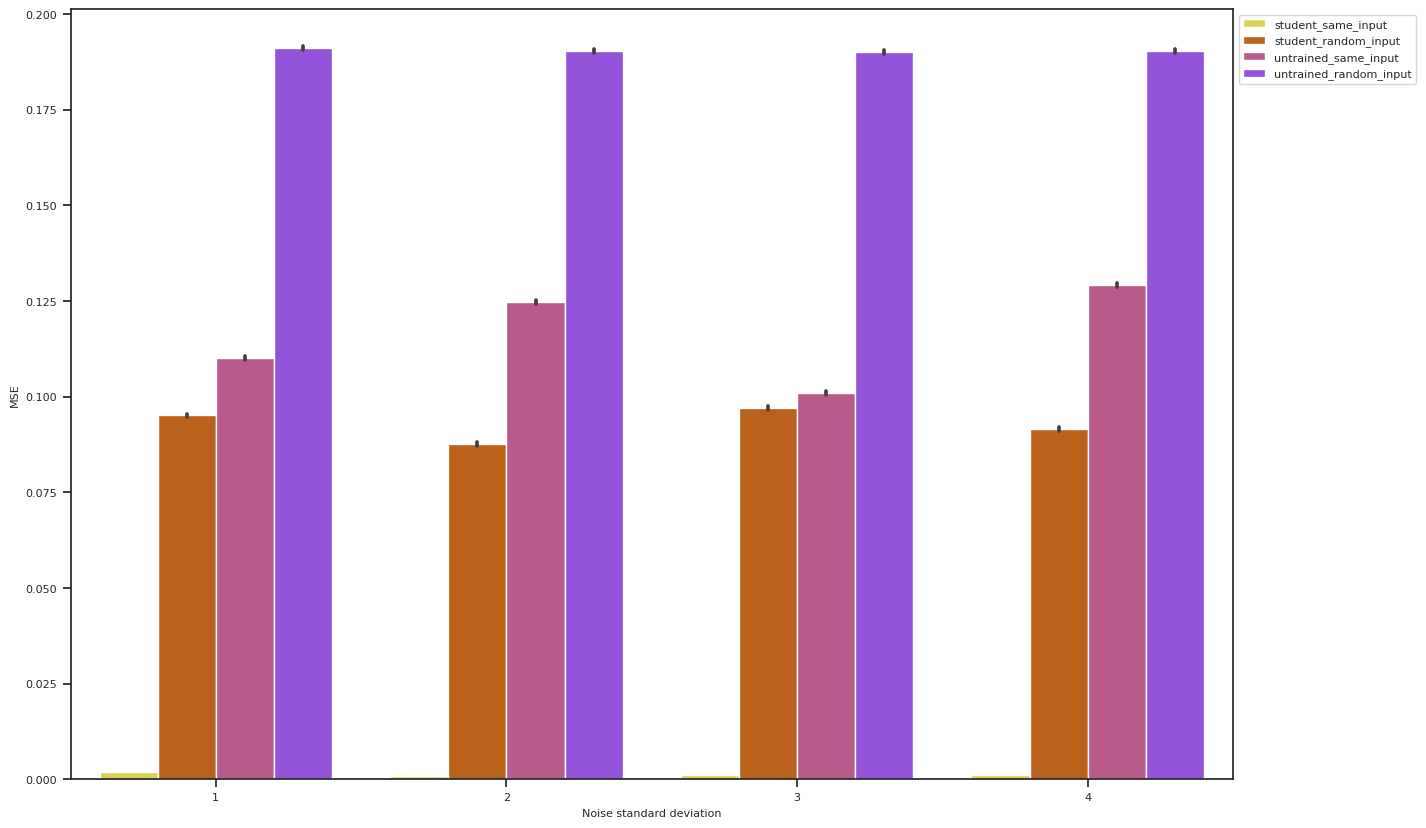

In [84]:
plt.figure(figsize=(15,10))
sns.barplot(data=df, x="noise_sd", y="sq_err", hue="model", palette=models_dict)
plt.xlabel("Noise standard deviation")
plt.ylabel("MSE")
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Noise_{experiment_name}_SQE_noise_sd_bar.pdf", bbox_inches="tight")
plt.show()

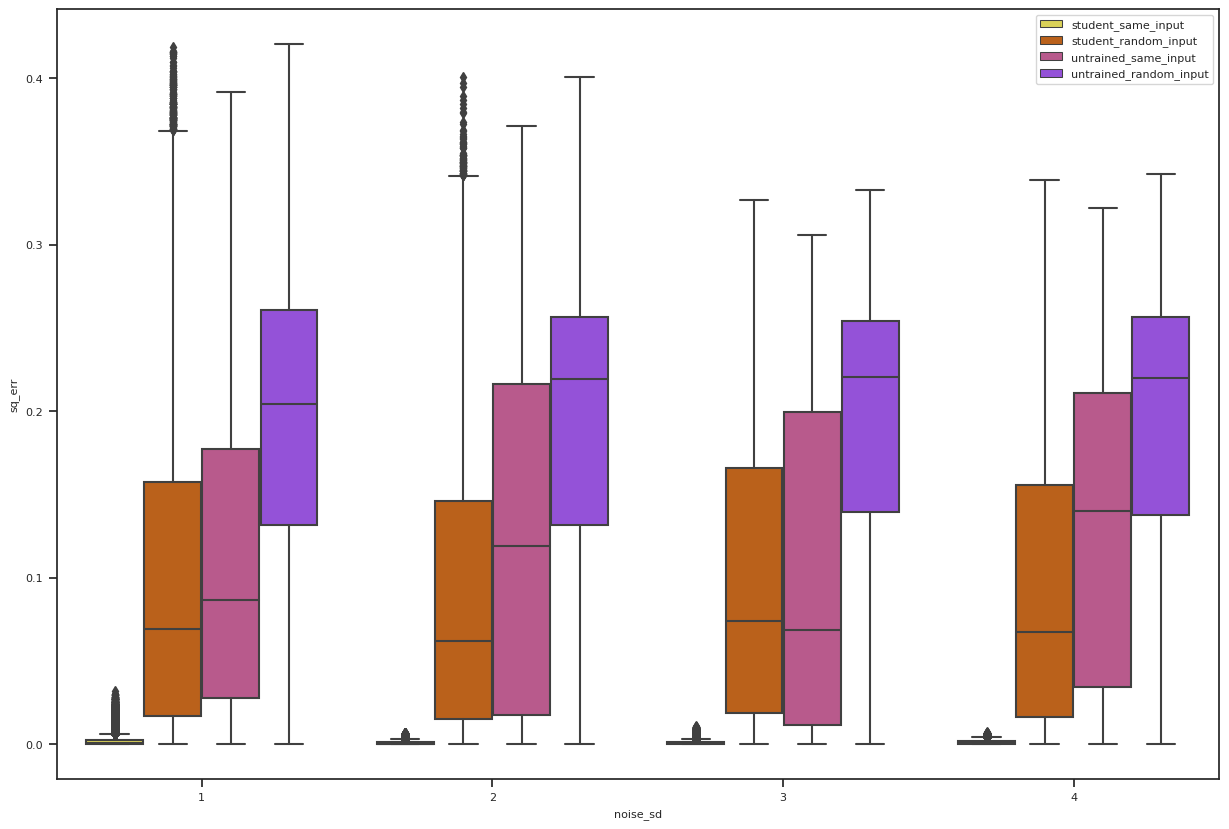

In [78]:
plt.figure(figsize=(15,10))
sns.boxplot(data=df, x="noise_sd", y="sq_err", hue="model", palette=models_dict)
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Noise_{experiment_name}_SQE_noise_sd_box.pdf", bbox_inches="tight")
plt.show()

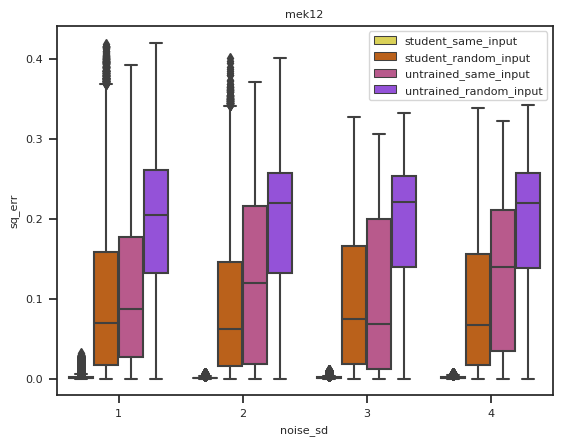

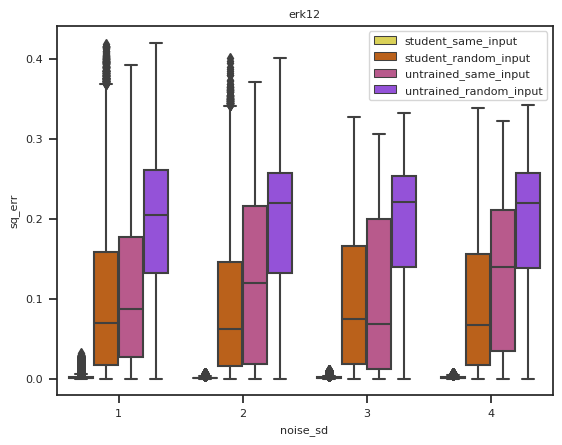

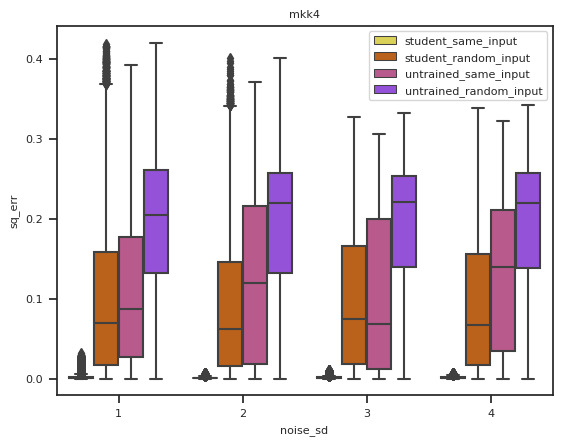

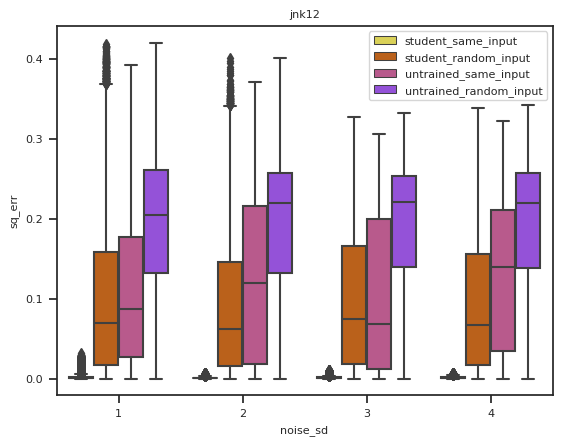

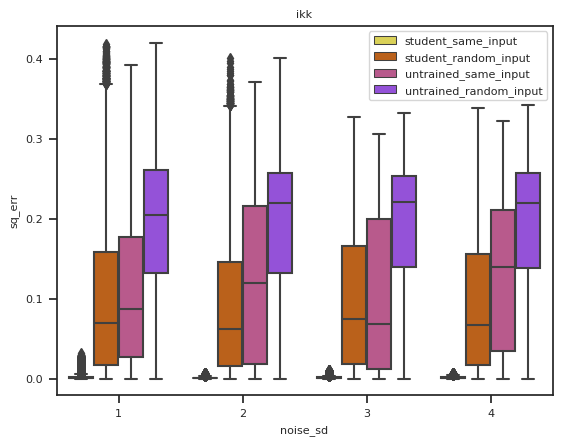

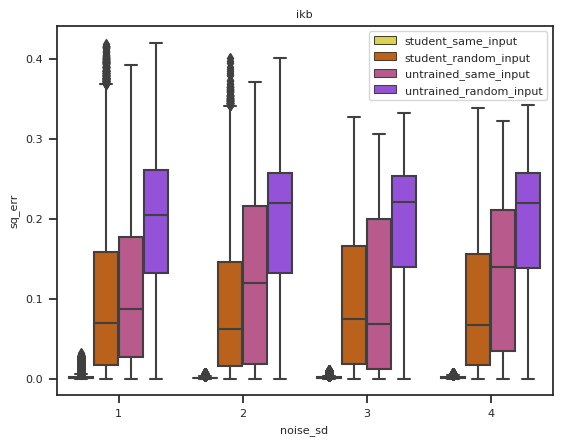

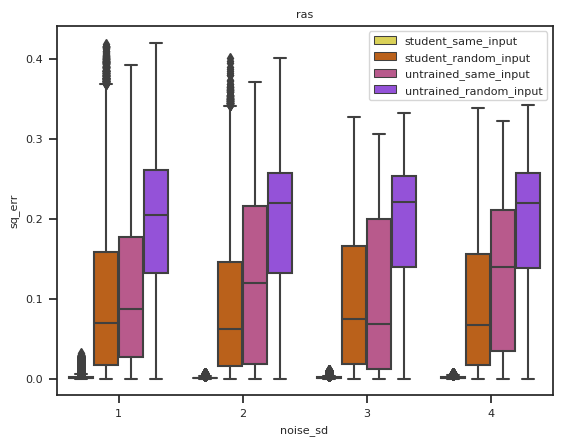

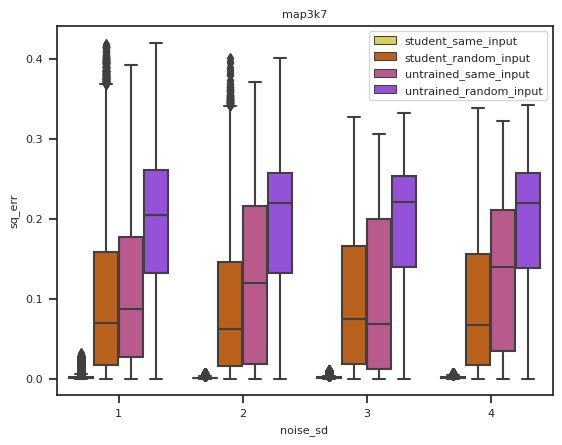

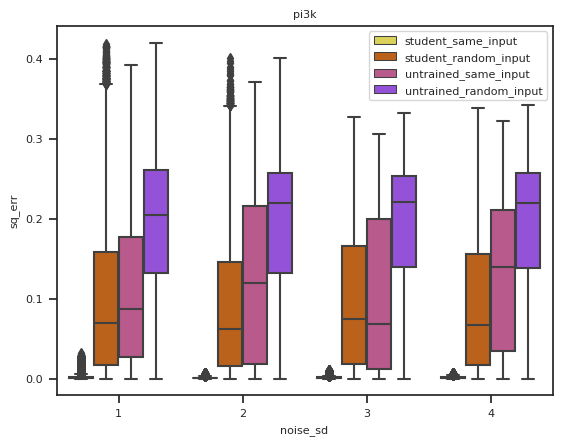

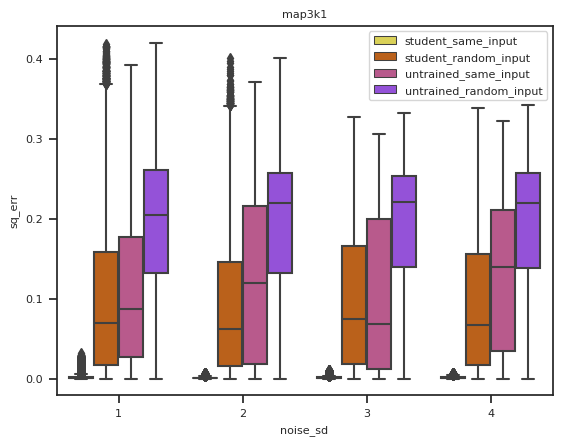

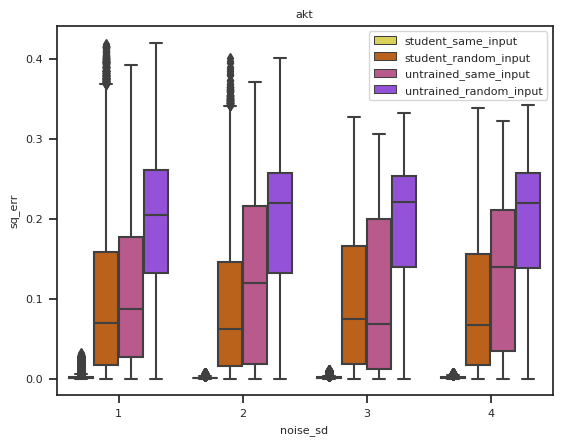

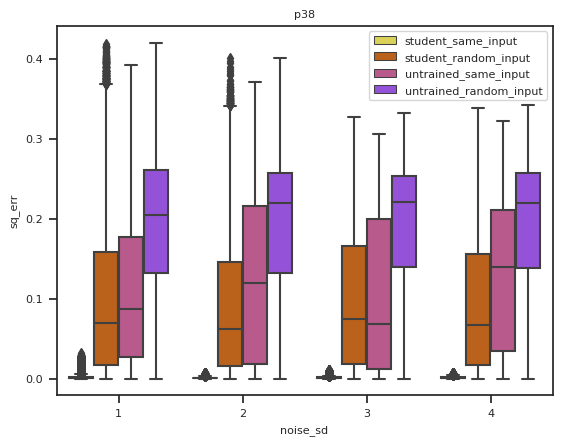

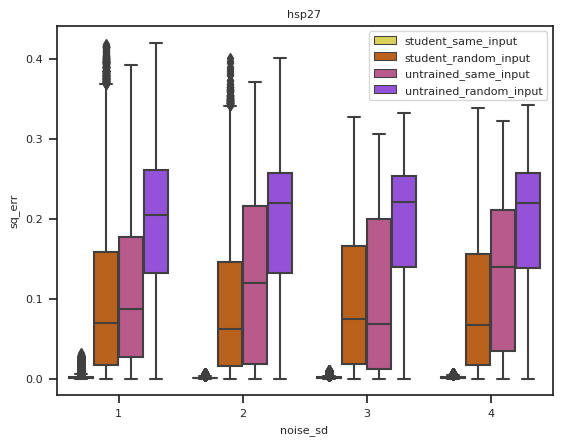

In [79]:
for n in df["marker"].unique():
    sel_df = df[df["marker"]==n]
    sns.boxplot(data=df, x="noise_sd", y="sq_err", hue="model", palette=models_dict)
    plt.legend(bbox_to_anchor=(1,1))
    plt.title(n)
    plt.savefig(f"/dccstor/ipc1/CAR/BFN/Figures/Noise_{experiment_name}_SQE_noise_sd_{n}_box.pdf", bbox_inches="tight")
    plt.show()

In [80]:
df.max()

noise_sd                        4
repeat                          5
model        untrained_same_input
marker                        ras
pred                          1.0
true                     0.648344
error                    0.648295
sq_err                   0.420286
abs_error                0.648295
dtype: object

<AxesSubplot:xlabel='noise_sd', ylabel='sq_err'>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


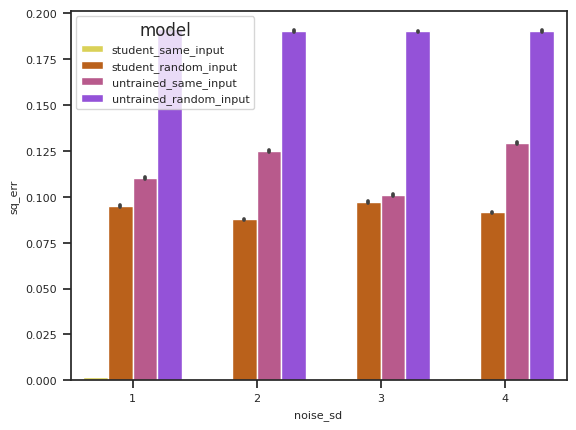

In [81]:
sns.barplot(data=df, x="noise_sd", y="sq_err", hue="model", palette=models_dict)
